In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py


from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization


plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

2024-11-07 14:28:28.181949: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 14:28:29.099708: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [16]:
moment = 2
obs = 'zg'

In [3]:
h5_filename = '../npfiles/jet_data.h5'
substructure_variables = ['pT', 'w', 'q', 'm', 'r', 'tau2s', 'tau21', 'zg', 'mult', 'sdm']
data_streams = ['_true', '_true_alt', '_reco', '_reco_alt']
n_variables = len(substructure_variables)

normalize = True

In [4]:
data_dict = {}
with h5py.File(h5_filename, 'r') as data:
    for var_name in data.keys():
        data_dict[var_name] = data[var_name][:150000]

xm = data_dict[obs + '_true'].mean()
xs = data_dict[obs + '_true'].std()
pm = data_dict['pT_true'].mean()
ps = data_dict['pT_true'].std()
if normalize:
    for var_name in substructure_variables:
        key = f"{var_name}{data_streams[0]}"
        mu = np.mean(data_dict[key])
        sigma = np.std(data_dict[key])
                
        for stream in data_streams:
            stream_key = f"{var_name}{stream}"
            data_dict[stream_key] = (data_dict[stream_key] - mu) / sigma

x_true = data_dict[obs + '_true']
x_true_alt = data_dict[obs + '_true_alt']
x_reco = data_dict[obs + '_reco']
x_reco_alt = data_dict[obs + '_reco_alt']

In [5]:
initializer = tf.keras.initializers.RandomUniform(minval=-1e-6, maxval=1e-6)

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.m = self.add_weight(name='m', 
                                    shape=(moment,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return tf.exp(sum([self.m[i]* x**(i+1) for i in range(moment)]))

In [6]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred)/weights_1 +
                         (1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

def weighted_binary_crossentropy_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss
    
    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)
    
    #tf.print("weights",weights_0,weights_1)
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = weights * ((1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

In [7]:
initial_learning_rate = 5e-3
decay_steps = 1000
decay_rate = 0.9

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=True)

In [8]:
myc = 1e-6


mymodel_inputtest = Input(shape=(1,))
mymodel_test = MyLayer(myc)(mymodel_inputtest)
model_generator = Model(mymodel_inputtest, mymodel_test)

inputs_disc = Input((1, ))
hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
model_discrimintor = Model(inputs=inputs_disc, outputs=outputs_disc)

model_discrimintor.compile(loss=weighted_binary_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))
    
model_discrimintor.trainable = False
mymodel_gan = Input(shape=(1,))
gan_model = Model(inputs=mymodel_gan,outputs=concatenate([model_discrimintor(mymodel_gan),model_generator(mymodel_gan)]))

gan_model.compile(loss=weighted_binary_crossentropy_GAN, optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule))

2024-11-07 14:28:36.825460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2647 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0
2024-11-07 14:28:36.827190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 2725 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1b:00.0, compute capability: 7.0
2024-11-07 14:28:36.828418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 12833 MB memory:  -> device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0000:3d:00.0, compute capability: 7.0
2024-11-07 14:28:36.829865: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 12833 MB memory:  -> device: 3, name: Tesla V100-SXM2-16GB, pci bus id: 

In [9]:
xvals_particle = np.concatenate([x_true_alt,x_true])
xvals_detector = np.concatenate([x_reco_alt,x_reco])
yvals = np.concatenate([np.ones(len(x_true_alt)),np.zeros(len(x_true))])

In [10]:
n_epochs = 20
n_batch = 128*10
n_batches = len(xvals_particle) // n_batch

xpn = (xvals_particle)
xdn = (xvals_detector)

In [11]:
for i in range(n_epochs):
    #print("  ",np.sum(model_generator.predict(X_train_1,batch_size=1000)))
    for j in range(n_batches):
        # if j%10 == 0:
        #     print(f"{j = }")
        X_batch_particle = xpn[j*n_batch:(j+1)*n_batch]
        X_batch_detector = xdn[j*n_batch:(j+1)*n_batch]
        Y_batch = yvals[j*n_batch:(j+1)*n_batch]
        W_batch = model_generator(X_batch_particle)
        W_batch = np.array(W_batch).flatten()
        
        W_batch[Y_batch==0] = 1        
        Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)
        
        model_discrimintor.train_on_batch(X_batch_detector, Y_batch_2)        
        gan_model.train_on_batch(X_batch_particle[Y_batch==0],Y_batch[Y_batch==0])
    mylambda = np.array(model_generator.layers[-1].get_weights())
    print("on epoch=", i, mylambda.T)

/global/home/users/krishdesai/anaconda3/envs/python3122/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")
I0000 00:00:1731018517.527580 1737254 service.cc:145] XLA service 0x7fc28c0250f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731018517.527604 1737254 service.cc:153]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1731018517.527608 1737254 service.cc:153]   StreamExecutor device (1): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1731018517.527610 1737254 service.cc:153]   StreamExecutor device (2): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1731018517.527612 1737254 service.cc:153]   StreamExecutor device (3): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1731018517.527614 1737254 service.cc:153]   StreamEx

on epoch= 0 [[-0.02081428]]
on epoch= 1 [[-0.05157627]]
on epoch= 2 [[-0.08683296]]
on epoch= 3 [[-0.12433353]]
on epoch= 4 [[-0.15925403]]
on epoch= 5 [[-0.19410387]]
on epoch= 6 [[-0.22868644]]
on epoch= 7 [[-0.26268113]]
on epoch= 8 [[-0.2930137]]
on epoch= 9 [[-0.32223478]]
on epoch= 10 [[-0.3506813]]
on epoch= 11 [[-0.37831384]]
on epoch= 12 [[-0.40417334]]
on epoch= 13 [[-0.42761812]]
on epoch= 14 [[-0.45040816]]
on epoch= 15 [[-0.4725536]]
on epoch= 16 [[-0.4940685]]
on epoch= 17 [[-0.51305085]]
on epoch= 18 [[-0.5314074]]
on epoch= 19 [[-0.5493013]]


In [12]:
arr = tf.exp(sum([mylambda[:,i]* x_true_alt**(i+1) for i in range(moment)]))
weights_moment_uf = np.concatenate([arr*len(x_true_alt)/np.sum(arr), np.ones(len(x_true))])
X_train_particle, X_test_particle, X_train_detector, X_test_detector, Y_train, Y_test, w_train, w_test = train_test_split(xvals_particle, 
                                                                                                       xvals_detector,
                                                                                                       yvals, weights_moment_uf)

In [13]:
weights_moment_uf

array([1.54435228, 0.91263537, 0.685994  , ..., 1.        , 1.        ,
       1.        ])

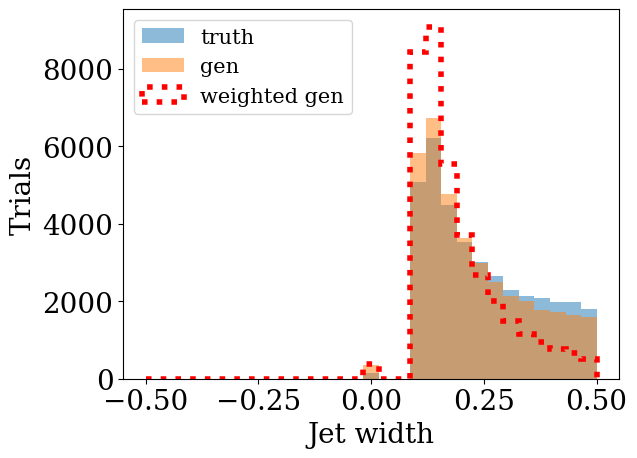

In [14]:
nbins = 30
bins = np.linspace(-0.5,0.5,nbins)

_,_,_=plt.hist(X_test_particle[Y_test==1]*xs + xm, bins=bins, alpha=0.5,label="truth")
_,_,_=plt.hist(X_test_particle[Y_test==0]*xs + xm, bins=bins, alpha=0.5,label="gen")
_,_,_=plt.hist(X_test_particle[Y_test==1]*xs + xm, bins=bins, weights=w_test[Y_test==1],histtype="step",color="r",ls=":", lw=4,label="weighted gen")
plt.legend(fontsize=15)
plt.xlabel("Jet width")
plt.ylabel("Trials")
plt.show()

In [19]:
print("Truth avg = ", np.mean((X_test_particle[Y_test==1]*xs + xm)**moment), 
      '±', np.std((X_test_particle[Y_test==1]*xs + xm)**moment)/np.sqrt(len(X_test_particle[Y_test==1])))
print("Gen avg = ", np.mean((X_test_particle[Y_test==0]*xs + xm)**moment), 
      '±', np.std((X_test_particle[Y_test==0]*xs + xm)**moment)/np.sqrt(len(X_test_particle[Y_test==0])))
print("Weighted gen avg = ", np.average((X_test_particle[Y_test==1]*xs + xm)**moment, weights = w_test[Y_test==1]))

Truth avg =  0.24536670418430462 ± 0.0006085018335724446
Gen avg =  0.23295922942879063 ± 0.0005964678447056757
Weighted gen avg =  0.1914518363891454


In [18]:
moment = 1